In [18]:
# !pip install -q -U langchain_experimental

In [19]:
from typing import Annotated, Sequence, List, Literal 
from pydantic import BaseModel, Field 
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults 
from langchain_groq import ChatGroq
from langgraph.types import Command 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent 
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_experimental.tools import PythonREPLTool

In [20]:
low_config_model = "llama-3.1-8b-instant"
mid_config_model = "meta-llama/llama-4-scout-17b-16e-instruct"
high_config_model = "llama-3.3-70b-versatile"

In [21]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv('Groq') # type: ignore
os.environ["TAVILY_API_KEY"] = os.getenv('Tavily') # type: ignore

In [22]:
from langchain_core.tools import tool

@tool
def web_search(query: str) -> str:
    """Search the web for current information and news."""
    tavily = TavilySearchResults(max_results=3)
    result = tavily.invoke(f"query: {query}")
    formatted_results = []
    
    if isinstance(result, list): 
        for item in result:
            if isinstance(item, dict): 
                title = item.get('title', 'No Title')
                url = item.get('url', 'No URL')
                content = item.get('content', 'No Content')
                truncated_content = (content[:200] + '...') if len(content) > 200 else content
                formatted_results.append(f"Title: {title}\nURL: {url}\nContent: {truncated_content}\n---")
    
    return f"Search Results:\n" + "\n".join(formatted_results)


In [23]:
python_repl_tool = PythonREPLTool()
python_repl_tool.invoke("x = 5; print([2*x for x in range(5)])")

'[0, 2, 4, 6, 8]\n'

In [24]:
llm = ChatGroq(model=high_config_model)

In [25]:
# class Supervisor(BaseModel):
#     next: Literal["enhancer", "researcher", "coder"] = Field(
#         description="Determines which specialist to activate next in the workflow sequence: "
#                     "'enhancer' when user input requires clarification, expansion, or refinement, "
#                     "'researcher' when additional facts, context, or data collection is necessary, "
#                     "'coder' when implementation, computation, or technical problem-solving is required."
#     )
#     reason: str = Field(
#         description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
#     )

# def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "researcher", "coder"]]:

#     system_prompt = ('''
                 
#         You are a workflow supervisor managing a team of three specialized agents: Prompt Enhancer, Researcher, and Coder. Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.

#         **Team Members**:
#         1. **Prompt Enhancer**: Always consider this agent first. They clarify ambiguous requests, improve poorly defined queries, and ensure the task is well-structured before deeper processing begins.
#         2. **Researcher**: Specializes in information gathering, fact-finding, and collecting relevant data needed to address the user's request.
#         3. **Coder**: Focuses on technical implementation, calculations, data analysis, algorithm development, and coding solutions.

#         **Your Responsibilities**:
#         1. Analyze each user request and agent response for completeness, accuracy, and relevance.
#         2. Route the task to the most appropriate agent at each decision point.
#         3. Maintain workflow momentum by avoiding redundant agent assignments.
#         4. Continue the process until the user's request is fully and satisfactorily resolved.

#         Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing unnecessary steps, ultimately delivering complete and accurate solutions to user requests.
                 
#     ''')
    
#     messages = [
#         {"role": "system", "content": system_prompt},  
#     ] + state["messages"] 

#     response = llm.with_structured_output(Supervisor).invoke(messages)

#     goto = response.next
#     reason = response.reason

#     print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")
    
#     return Command(
#         update={
#             "messages": [
#                 HumanMessage(content=reason, name="supervisor")
#             ]
#         },
#         goto=goto,  
#     )

In [26]:
def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "researcher", "coder"]]:
    
    system_prompt = '''You are a workflow supervisor managing a team of three specialized agents: Prompt Enhancer, Researcher, and Coder. 

Your role is to decide which agent should handle the task next. Respond with ONLY the agent name and reason in this exact format:

AGENT: [enhancer/researcher/coder]
REASON: [your detailed justification]

**Team Members**:
1. **enhancer**: Always consider this agent first. They clarify ambiguous requests, improve poorly defined queries, and ensure the task is well-structured before deeper processing begins.
2. **researcher**: Specializes in information gathering, fact-finding, and collecting relevant data needed to address the user's request.
3. **coder**: Focuses on technical implementation, calculations, data analysis, algorithm development, and coding solutions.

**Decision Guidelines**:
- Choose 'enhancer' when user input requires clarification, expansion, or refinement
- Choose 'researcher' when additional facts, context, or data collection is necessary
- Choose 'coder' when implementation, computation, or technical problem-solving is required

Analyze the current conversation and determine which specialist should handle the task next.'''
    
    # Create the full prompt with conversation history - FIXED VERSION
    conversation_text = ""
    for msg in state["messages"]:
        # Handle different message types
        if hasattr(msg, 'type'):
            role = 'user' if msg.type == 'human' else msg.type
        else:
            role = 'user'  # default fallback
        
        content = getattr(msg, 'content', '')
        conversation_text += f"{role}: {content}\n"
    
    full_prompt = f"{system_prompt}\n\nConversation History:\n{conversation_text}\n\nWhich agent should handle this next?"
    
    try:
        response = llm.invoke(full_prompt)
        response_content = response.content.strip()
        
        print("--- Supervisor Response ---")
        print(response_content)
        print("--- End Response ---")
        
        # Parse the response to extract agent and reason
        lines = response_content.split('\n')
        goto = None
        reason = ""
        
        for line in lines:
            line = line.strip()
            if line.startswith('AGENT:'):
                agent_part = line.replace('AGENT:', '').strip().lower()
                # Extract just the agent name
                if 'enhancer' in agent_part:
                    goto = 'enhancer'
                elif 'researcher' in agent_part:
                    goto = 'researcher'
                elif 'coder' in agent_part:
                    goto = 'coder'
            elif line.startswith('REASON:'):
                reason = line.replace('REASON:', '').strip()
        
        # Fallback parsing if the exact format isn't followed
        if not goto:
            response_lower = response_content.lower()
            if 'enhancer' in response_lower:
                goto = 'enhancer'
            elif 'researcher' in response_lower:
                goto = 'researcher'
            elif 'coder' in response_lower:
                goto = 'coder'
            else:
                # Default fallback
                goto = 'enhancer'
                reason = "Defaulting to enhancer for task clarification"
        
        if not reason:
            reason = "Agent selected based on task requirements"
            
    except Exception as e:
        print(f"Error in supervisor decision: {e}")
        # Default fallback
        goto = 'enhancer'
        reason = "Error occurred, defaulting to enhancer for task clarification"

    print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")
    print(f"Reason: {reason}")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,  
    )

In [27]:
def enhancer_node(state: MessagesState) -> Command[Literal["supervisor"]]:

    """
        Enhancer agent node that improves and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the supervisor.
    """
   
    system_prompt = (
        "You are a Query Refinement Specialist with expertise in transforming vague requests into precise instructions. Your responsibilities include:\n\n"
        "1. Analyzing the original query to identify key intent and requirements\n"
        "2. Resolving any ambiguities without requesting additional user input\n"
        "3. Expanding underdeveloped aspects of the query with reasonable assumptions\n"
        "4. Restructuring the query for clarity and actionability\n"
        "5. Ensuring all technical terminology is properly defined in context\n\n"
        "Important: Never ask questions back to the user. Instead, make informed assumptions and create the most comprehensive version of their request possible."
    )

    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"]  

    enhanced_query = llm.invoke(messages)

    print(f"--- Workflow Transition: Prompt Enhancer → Supervisor ---")

    return Command(
        update={
            "messages": [  
                HumanMessage(
                    content=enhanced_query.content, 
                    name="enhancer"  
                )
            ]
        },
        goto="supervisor", 
    )

In [28]:
def research_node(state: MessagesState) -> Command[Literal["validator"]]:

    """
        Research agent node that gathers information using Tavily search.
        Takes the current task state, performs relevant research,
        and returns findings for validation.
    """
    
    research_agent = create_react_agent(
        llm,  
        tools=[web_search],  
        state_modifier= "You are an Information Specialist with expertise in comprehensive research. Your responsibilities include:\n\n"
            "1. Identifying key information needs based on the query context\n"
            "2. Gathering relevant, accurate, and up-to-date information from reliable sources\n"
            "3. Organizing findings in a structured, easily digestible format\n"
            "4. Citing sources when possible to establish credibility\n"
            "5. Focusing exclusively on information gathering - avoid analysis or implementation\n\n"
            "Provide thorough, factual responses without speculation where information is unavailable."
    )

    result = research_agent.invoke(state)

    print(f"--- Workflow Transition: Researcher → Validator ---")

    return Command(
        update={
            "messages": [ 
                HumanMessage(
                    content=result["messages"][-1].content,  
                    name="researcher"  
                )
            ]
        },
        goto="validator", 
    )

In [29]:
def code_node(state: MessagesState) -> Command[Literal["validator"]]:

    code_agent = create_react_agent(
        llm,
        tools=[python_repl_tool],
        state_modifier=(
            "You are a coder and analyst. Focus on mathematical calculations, analyzing, solving math questions, "
            "and executing code. Handle technical problem-solving and data tasks."
        )
    )

    result = code_agent.invoke(state)

    print(f"--- Workflow Transition: Coder → Validator ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="validator",
    )

In [30]:
# # System prompt providing clear instructions to the validator agent
# system_prompt = '''
#     Your task is to ensure reasonable quality. 
#     Specifically, you must:
#     - Review the user's question (the first message in the workflow).
#     - Review the answer (the last message in the workflow).
#     - If the answer addresses the core intent of the question, even if not perfectly, signal to end the workflow with 'FINISH'.
#     - Only route back to the supervisor if the answer is completely off-topic, harmful, or fundamentally misunderstands the question.
    
#     - Accept answers that are "good enough" rather than perfect
#     - Prioritize workflow completion over perfect responses
#     - Give benefit of doubt to borderline answers
    
#     Routing Guidelines:
#     1. 'supervisor' Agent: ONLY for responses that are completely incorrect or off-topic.
#     2. Respond with 'FINISH' in all other cases to end the workflow.
# '''

# class Validator(BaseModel):
#     next: Literal["supervisor", "FINISH"] = Field(
#         description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
#     )
#     reason: str = Field(
#         description="The reason for the decision."
#     )

# def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:

#     user_question = state["messages"][0].content
#     agent_answer = state["messages"][-1].content

#     messages = [
#         {"role": "system", "content": system_prompt},
#         {"role": "user", "content": user_question},
#         {"role": "assistant", "content": agent_answer},
#     ]

#     response = llm.with_structured_output(Validator).invoke(messages)

#     goto = response.next
#     reason = response.reason

#     if goto == "FINISH" or goto == END:
#         goto = END  
#         print(" --- Transitioning to END ---")  
#     else:
#         print(f"--- Workflow Transition: Validator → Supervisor ---")
 

#     return Command(
#         update={
#             "messages": [
#                 HumanMessage(content=reason, name="validator")
#             ]
#         },
#         goto=goto, 
#     )

In [31]:
def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:
    
    system_prompt = '''You are a workflow validator responsible for ensuring reasonable quality responses.

Your task is to review the conversation and decide whether to finish or continue the workflow.

Respond with ONLY this exact format:
DECISION: [FINISH/supervisor]
REASON: [your detailed justification]

**Review Guidelines**:
- Review the user's original question and the final answer provided
- If the answer addresses the core intent of the question, even if not perfectly, respond with 'FINISH'
- Only respond with 'supervisor' if the answer is completely off-topic, harmful, or fundamentally misunderstands the question

**Decision Criteria**:
- Accept answers that are "good enough" rather than perfect
- Prioritize workflow completion over perfect responses  
- Give benefit of doubt to borderline answers
- Choose 'FINISH' in most cases to end the workflow
- Choose 'supervisor' ONLY for responses that are completely incorrect or off-topic

Based on the conversation below, should the workflow finish or continue?'''

    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content

    # Create the full prompt
    full_prompt = f"""{system_prompt}

Original User Question: {user_question}

Latest Agent Response: {agent_answer}

Should this workflow FINISH or go back to supervisor?"""

    try:
        response = llm.invoke(full_prompt)
        response_content = response.content.strip()
        
        print("--- Validator Response ---")
        print(response_content)
        print("--- End Response ---")
        
        # Parse the response to extract decision and reason
        lines = response_content.split('\n')
        goto = None
        reason = ""
        
        for line in lines:
            line = line.strip()
            if line.startswith('DECISION:'):
                decision_part = line.replace('DECISION:', '').strip().upper()
                if 'FINISH' in decision_part:
                    goto = 'FINISH'
                elif 'SUPERVISOR' in decision_part:
                    goto = 'supervisor'
            elif line.startswith('REASON:'):
                reason = line.replace('REASON:', '').strip()
        
        # Fallback parsing if the exact format isn't followed
        if not goto:
            response_lower = response_content.lower()
            if 'finish' in response_lower:
                goto = 'FINISH'
            elif 'supervisor' in response_lower:
                goto = 'supervisor'
            else:
                # Default to finishing the workflow (bias toward completion)
                goto = 'FINISH'
                reason = "Defaulting to finish workflow"
        
        if not reason:
            reason = "Decision made based on response quality assessment"
            
    except Exception as e:
        print(f"Error in validator decision: {e}")
        # Default to finishing the workflow on error
        goto = 'FINISH'
        reason = "Error occurred, defaulting to finish workflow"

    # Convert FINISH to the actual end state
    if goto == "FINISH":
        goto = "__end__"  # or whatever your END constant is
        print(" --- Transitioning to END ---")
        print(f"Reason: {reason}")
    else:
        print(f"--- Workflow Transition: Validator → Supervisor ---")
        print(f"Reason: {reason}")

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="validator")
            ]
        },
        goto=goto, 
    )

In [32]:
graph = StateGraph(MessagesState)

graph.add_node("supervisor", supervisor_node) 
graph.add_node("enhancer", enhancer_node)  
graph.add_node("researcher", research_node) 
graph.add_node("coder", code_node) 
graph.add_node("validator", validator_node)  

graph.add_edge(START, "supervisor")  
app = graph.compile()

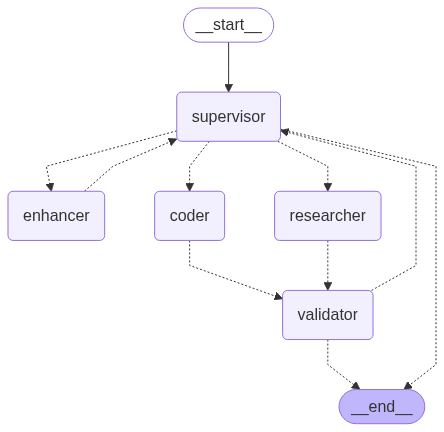

In [33]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [34]:
import pprint

inputs = {
    "messages": [
        ("user", "Road & traffic conition of Belghoria Expressway on today"),
    ]
}

for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value["messages"][-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()

--- Supervisor Response ---
AGENT: enhancer
REASON: The user's input "Road & traffic conition of Belghoria Expressway on today" contains a typo ("conition" instead of "condition") and lacks specificity regarding the type of information or assistance needed. The enhancer should handle this task next to clarify the user's request, correct any errors, and refine the query to ensure it is well-structured before proceeding with further processing or information gathering.
--- End Response ---
--- Workflow Transition: Supervisor → ENHANCER ---
Reason: The user's input "Road & traffic conition of Belghoria Expressway on today" contains a typo ("conition" instead of "condition") and lacks specificity regarding the type of information or assistance needed. The enhancer should handle this task next to clarify the user's request, correct any errors, and refine the query to ensure it is well-structured before proceeding with further processing or information gathering.
"Output from node 'superviso

In [35]:
import pprint

inputs = {
    "messages": [
        ("user", "Give me the 20th fibonacci number"),
    ]
}
for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

--- Supervisor Response ---
AGENT: enhancer
REASON: The user's request is direct but lacks context or clarification on whether they want the Fibonacci number calculated using a specific method (e.g., recursive, iterative) or if there are any particular constraints (e.g., using a certain programming language). The enhancer should first assess the request to ensure it's well-defined and to clarify any ambiguities before proceeding with the calculation.
--- End Response ---
--- Workflow Transition: Supervisor → ENHANCER ---
Reason: The user's request is direct but lacks context or clarification on whether they want the Fibonacci number calculated using a specific method (e.g., recursive, iterative) or if there are any particular constraints (e.g., using a certain programming language). The enhancer should first assess the request to ensure it's well-defined and to clarify any ambiguities before proceeding with the calculation.
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(

In [47]:
import pprint


user_input="""Given a binary tree and an integer k, the task is to count the number of paths in the tree such that the sum of the nodes in each path equals k.
A path can start from any node and end at any node and must be downward only. Tell me  the number of paths when k=7 
an here is the Binary tree

        1
       / \
      2   3
     / \   \
    4   5   2

"""

inputs = {
    "messages": [
        ("user", user_input),
    ]
}
for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

--- Supervisor Response ---
AGENT: coder
REASON: The user has provided a clear problem statement, including a binary tree structure and a specific value for k. The task requires counting the number of paths in the tree where the sum of the nodes equals k, which involves implementation, computation, and technical problem-solving. Since the problem is well-defined and the input is structured, the coder is the most suitable agent to handle this task next, as they can focus on developing a solution to calculate the number of paths that meet the given condition.
--- End Response ---
--- Workflow Transition: Supervisor → CODER ---
Reason: The user has provided a clear problem statement, including a binary tree structure and a specific value for k. The task requires counting the number of paths in the tree where the sum of the nodes equals k, which involves implementation, computation, and technical problem-solving. Since the problem is well-defined and the input is structured, the coder is t

In [ ]:
# --- Workflow Transition: Coder → Validator ---
# "Output from node 'coder':"
# { 'messages': [ 
# HumanMessage(content='The number of paths in the binary tree where 
# the sum of the nodes equals 7 is 2.', additional_kwargs={}, 
# response_metadata={}, name='coder', id='a45a9d03-ad9d-4308-a97c-f68bf9520a20')]}

1
